### Import Data

In [1]:
#import library
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime

In [2]:
#import gender data
gender = pd.read_csv("C:/Users/Flora Huang/Desktop/Personalization/gender.txt", sep=",", header=None)
gender.columns = ["UserID", "Gender"]

In [3]:
#import ratings data
ratings = pd.read_csv("C:/Users/Flora Huang/Desktop/Personalization/ratings.dat", sep=",",header=None,error_bad_lines=False)
ratings.columns = ["UserID","ProfileID","Rating"]

b'Skipping line 883329: expected 3 fields, saw 4\n'


### Functions

In [4]:
#subset data
def subsetdata(data, by, k):
    #how to subset
    if by == "UserID":
        other = "ProfileID"
    else:
        other = "UserID"
    
    #subset top users/items
    group_data = data.groupby([by]).count().sort_values(by=other, ascending=False).reset_index().loc[:,by]
    subsetid = group_data[:1000]
    subset = data[data.loc[:,by].isin(subsetid)].copy()
    
    #create 1st mapping - subset
    subsetmap = {}
    for i in range(len(subsetid)):
        subsetmap[subsetid[i]] = i
    subset.loc[:,by] = subset.loc[:,by].map(subsetmap)
    
    #subset secondary axis
    subset = subset[subset[other].isin(subsetid)]
    subset.loc[:,other] = subset.loc[:,other].map(subsetmap)
    
    ratingmat1000 = pd.crosstab(index=subset.loc[:,"UserID"], columns=subset.loc[:,"ProfileID"],values=subset.loc[:,"Rating"], aggfunc="mean")
    ratingkid = ratingmat1000.columns[0:k]
    ratingmatk = ratingmat1000.loc[ratingmat1000.index.isin(ratingkid),:]
    ratingmatk = ratingmatk.loc[:,ratingmatk.columns.isin(ratingkid)]
    
    #create 2nd mapping - subset
    ratingmap = {}
    for i in range(len(ratingmatk.index)):
        ratingmap[ratingmatk.index[i]] = i
    
    # create rating dataframe - nan
    df_ratingmat = ratingmatk.reset_index(drop=True)
    df_ratingmat.columns = range(df_ratingmat.shape[1])
    
    return df_ratingmat,subsetmap, ratingmap

In [5]:
#split data into training and testing set
def train_test_split(data):
    test = np.empty(data.shape)
    test[:] = np.nan
    train = data.values.copy()
    data_mat = data.values.copy()
    
    for user in range(data.shape[0]):
        nonnaindex = np.argwhere(~np.isnan(data_mat[user,:])).T[0,:]
        nonnaindex_len = int(len(nonnaindex)/5)
        if nonnaindex_len>0:
            test_ratings = np.random.choice(nonnaindex,size=nonnaindex_len,replace=False)
            train[user, test_ratings] = np.nan
            test[user, test_ratings] = data_mat[user, test_ratings]
    
    # Test and training need to be disjoint
    assert(np.isnan(train*test).sum()==data.shape[0]*data.shape[1]) 
    return train, test

In [6]:
#functions used in pearson correlation calculation
def meandiff(x,mean):
    return (x-mean)**2

def mindiff(x,mean):
    return (x-mean)

In [7]:
#constructs similarity matrix of users/items based on pearson correlation
def pearsoncorr(data):
    corrmatrix = np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if i==j:
                corrmatrix[i,j]=1
            else:
                #calculate the average rating of user
                mi = np.nanmean(data[i,:])
                mj = np.nanmean(data[j,:])
                #find items(profiles) that both user have rated
                nonemptyi = np.argwhere(~np.isnan(data[i,:])).T[0,:]
                nonemptyj = np.argwhere(~np.isnan(data[j,:])).T[0,:]
                bothnonempty = np.intersect1d(nonemptyi,nonemptyj)
                temp = data[:,bothnonempty]
                #calculate standard deviation of items that both users have rated
                sdi = np.nansum(np.apply_along_axis(meandiff,0,temp[i,:],mi))**(0.5)
                sdj = np.nansum(np.apply_along_axis(meandiff,0,temp[j,:],mj))**(0.5)

                if sdi==0 or sdj==0:
                    corrmatrix[i,j] = 0
                else:
                    corrmatrix[i,j]= np.dot(np.apply_along_axis(mindiff,0,temp[i,:],mi),np.apply_along_axis(mindiff,0,temp[j,:],mj))/(sdi*sdj)
    return corrmatrix

In [8]:
#predict user's rating
def preduser(data, sim, k, kind):
    pred = np.zeros(data.shape)
    if kind == "User":
        user_bias = np.nanmean(data,axis=1)
        user_bias[np.isnan(user_bias)] = 0
        rating = data-user_bias[:,np.newaxis]
        for i in range(data.shape[0]):
            k_neighbor = np.argsort(sim[:,i])[::-1][:k]
            k_neighbor = k_neighbor[~np.equal(k_neighbor, i)]
            for j in range(data.shape[1]):
                if i==j:
                    pred[i,j] = np.nan
                else:
                    pred[i,j] = np.nansum(sim[i,:][k_neighbor]*data[:,j][k_neighbor])
                    pred[i,j] /= np.nansum(np.abs(sim[i,:][k_neighbor]))
                    pred[i,j] += user_bias[i]
    else:
        item_bias = np.nanmean(data,axis=0)
        item_bias[np.isnan(item_bias)] = 0
        rating = data-item_bias[np.newaxis,:]
        for j in range(data.shape[1]):
            k_neighbor = np.argsort(sim[:,j])[::-1][:k]
            k_neighbor = k_neighbor[~np.equal(k_neighbor, j)]
            for i in range(data.shape[0]):
                if i==j:
                    pred[i,j] = np.nan
                else:
                    pred[i,j] = np.nansum(sim[j,:][k_neighbor]*data[i,:][k_neighbor].T)
                    pred[i,j] /= np.nansum(np.abs(sim[j,:][k_neighbor]))
                    pred[i,j] += item_bias[j]
            
    return pred

In [10]:
#calculate mean squared error and mean absolute error
from sklearn.metrics import mean_squared_error, mean_absolute_error
def get_mse(pred, actual):
    # Ignore nan terms.
    pred_nr = pred[np.where(~np.isnan(actual))]
    actual_nr = actual[np.where(~np.isnan(actual))]
 
    if len(np.where(np.isnan(pred_nr))[0])>0:
        pred_nr = pred_nr[np.where(~np.isnan(pred_nr))]
        actual_nr = actual_nr[np.where(~np.isnan(pred_nr))]
    
    if len(pred_nr)>1 and len(actual_nr)>1:
        mse = mean_squared_error(pred_nr, actual_nr)
    else:
        mse = np.nan
    
    return mse

def get_mae(pred, actual):
    # Ignore nan terms.
    pred_nr = pred[np.where(~np.isnan(actual))]
    actual_nr = actual[np.where(~np.isnan(actual))]
 
    if len(np.where(np.isnan(pred_nr))[0])>0:
        pred_nr = pred_nr[np.where(~np.isnan(pred_nr))]
        actual_nr = actual_nr[np.where(~np.isnan(pred_nr))]
    
    if len(pred_nr)>0 and len(actual_nr)>0:
        mae = mean_absolute_error(pred_nr, actual_nr)
    else:
        mae = np.nan
    
    return mae

In [11]:
def tunehyperparam(maxk, span, train, test, sims, error, kind):
    k_array = np.array(range(0,maxk,span))
    train_accuracy = []
    test_accuracy = []
    
    for k in k_array:
        pred_mat = preduser(train, sims, k, kind)
        
        if error == "MSE":
            train_accuracy += [get_mse(pred_mat, train)]
            test_accuracy += [get_mse(pred_mat, test)]
        else:
            train_accuracy += [get_mae(pred_mat, train)]
            test_accuracy += [get_mae(pred_mat, test)]
    
    optimal_kind = np.nanargmin(np.array(train_accuracy))
    optimal_k = k_array[optimal_kind]
    prediction = preduser(train, sims, optimal_k, kind)
    
    if error == "MSE":
        print("Training data's MSE with the optimal_k " + str(optimal_k) + " is " + str(train_accuracy[optimal_kind]))
        print("Test data's MSE with the optimal_k " + str(optimal_k) + " is " + str(test_accuracy[optimal_kind]))
    else:
        print("Training data's MAE with the optimal_k " + str(optimal_k) + " is " + str(train_accuracy[optimal_kind]))
        print("Test data's MAE with the optimal_k " + str(optimal_k) + " is " + str(test_accuracy[optimal_kind]))
    
    return prediction, train_accuracy, test_accuracy

In [13]:
import seaborn as sns
import matplotlib as matplt
import matplotlib.pyplot as plt

def ploterror(k_array, user_train_mse, user_test_mse, item_train_mse, item_test_mse, kind):
    pal = sns.color_palette("Set2", 2)

    matplt.figure.Figure(figsize=(2000,2000))
    plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=3)
    plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=3)
    plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=3)
    plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=3)
    plt.legend(loc='best', fontsize=6)
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    plt.xlabel('k', fontsize=14);
    plt.ylabel(kind, fontsize=14);
    plt.show()

### Full function of calculating user-based and item-based rating prediction

In [14]:
def RecommenderSystem(ratings, sizeofsubset, max_k, kspan, nrecuser):
    print("-------Recommender system starts now--------")
    starttime = datetime.datetime.now()
    #rating matrix and subset map of top active users
    df_ratingmat, subsetmap, ratingmap = subsetdata(ratings, "UserID", sizeofsubset)
    
    #training and testing data
    train, test = train_test_split(df_ratingmat,)
    
    #print the sparsity of data
    trainsparsity = float(len(np.argwhere(~np.isnan(train[:])).T[0,:]))
    trainsparsity /= (train.shape[0] * train.shape[1])
    trainsparsity *= 100
    print("Sparsity of user training data: {:4.2f}%".format(trainsparsity))

    #simulation matrix
    user_sims = pearsoncorr(train)
    item_sims = pearsoncorr(train.T)
    
    #get prediction and accuracy metric
    max_k_neighbor = max_k
    k_span = kspan
    
    print("===User-based Collaborative Filtering Model===")
    print("---MSE---")
    op_user_pred_mse, user_train_mse, user_test_mse = tunehyperparam(max_k_neighbor,k_span,train,test,user_sims,"MSE","User")
    print("---MAE---")
    op_user_pred_mae, user_train_mae, user_test_mae = tunehyperparam(max_k_neighbor,k_span,train,test,user_sims,"MAE","User")
    print("===Item-based Collaborative Filtering Model===")
    print("---MSE---")
    op_item_pred_mse, item_train_mse, item_test_mse = tunehyperparam(max_k_neighbor,k_span,train,test,item_sims,"MSE","Item")
    print("---MAE---")
    op_item_pred_mae, item_train_mae, item_test_mae = tunehyperparam(max_k_neighbor,k_span,train,test,item_sims,"MAE","Item")
    
    #plot accuracy metric
    k_array = np.array(range(0,max_k_neighbor,k_span))
    ploterror(k_array, user_train_mse, user_test_mse, item_train_mse, item_test_mse, "MSE")
    ploterror(k_array, user_train_mse, user_test_mse, item_train_mse, item_test_mse, "MAE")
    
    #createinversemap
    inv_rating_u = {v: k for k, v in ratingmap.items()}
    userinvrating = np.vectorize(inv_rating_u.get)(pd.DataFrame(op_user_pred_mse).index)
    inv_subset_u = {v: k for k, v in subsetmap.items()}
    user_index = np.vectorize(inv_subset_u.get)(userinvrating)
    
    #recommend the first user
    target_user = user_index[0]
    #user-mse
    ind_byusermse = np.argpartition(op_user_pred_mse[0,:], -nrecuser)
    ind_byusermse = ind_byusermse[~np.equal(ind_byusermse, 0)][-nrecuser:][::-1]
    rec_byusermse = user_index[ind_byusermse]
    #user-mae
    ind_byusermae = np.argpartition(op_user_pred_mae[0,:], -nrecuser)
    ind_byusermae = ind_byusermae[~np.equal(ind_byusermae, 0)][-nrecuser:][::-1]
    rec_byusermae = user_index[ind_byusermae]
    #item-mse
    ind_byitemmse = np.argpartition(op_item_pred_mse[:,0], -nrecuser)[nrecuser:]
    ind_byitemmse = ind_byitemmse[~np.equal(ind_byitemmse, 0)][-nrecuser:][::-1]
    rec_byitemmse = user_index[ind_byitemmse]
    #item-mae
    ind_byitemmae = np.argpartition(op_item_pred_mae[:,0], -nrecuser)[nrecuser:]
    ind_byitemmae = ind_byitemmae[~np.equal(ind_byitemmae, 0)][-nrecuser:][::-1]
    rec_byitemmae = user_index[ind_byitemmae]
    
    print("The recommendation for user "+str(target_user)+" is\n")
    print("By User-based MSE: User "+str(rec_byusermse)+"\n")
    print("By User-based MAE: User "+str(rec_byusermae)+"\n")
    print("By Item-based MSE: User "+str(rec_byitemmse)+"\n")
    print("By Item-based MAE: User "+str(rec_byitemmae)+"\n")
    
    endtime = datetime.datetime.now()
    
    print("=============================================")
    print("The runtime of recommending data size of " + str(sizeofsubset) + " is " + str(endtime-starttime))
    return 0

### 100 Users

-------Recommender system starts now--------
Sparsity of user training data: 11.33%
===User-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 16 is 7.61589609797
Test data's MSE with the optimal_k 16 is 9.4930108814
---MAE---
Training data's MAE with the optimal_k 16 is 2.26801028182
Test data's MAE with the optimal_k 16 is 2.55716303593
===Item-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 6 is 13.5828854247
Test data's MSE with the optimal_k 6 is 14.3928179159
---MAE---
Training data's MAE with the optimal_k 6 is 3.0112164593
Test data's MAE with the optimal_k 6 is 3.11449140374


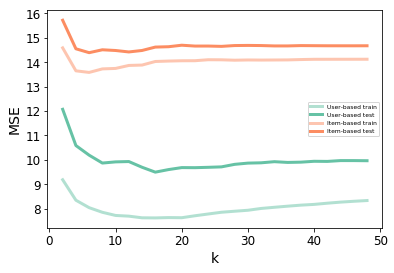

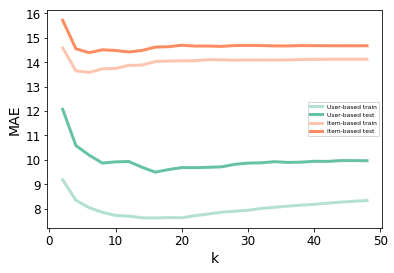

The recommendation for user 90280 is

By User-based MSE: User [ 33639  64438    720  24402 131976]

By User-based MAE: User [ 33639  64438    720  24402 131976]

By Item-based MSE: User [104712  77713  71873  71099  56792]

By Item-based MAE: User [104712  77713  71873  71099  56792]

The runtime of recommending data size of 100 is 0:00:39.508926


0

In [18]:
RecommenderSystem(ratings, 100, 50, 2, 5)

### 200 Users

-------Recommender system starts now--------
Sparsity of user training data: 9.04%
===User-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 36 is 7.34735021338
Test data's MSE with the optimal_k 36 is 8.97052452917
---MAE---
Training data's MAE with the optimal_k 46 is 2.2184793898
Test data's MAE with the optimal_k 46 is 2.44723849822
===Item-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 8 is 13.457112475
Test data's MSE with the optimal_k 8 is 13.9378639623
---MAE---
Training data's MAE with the optimal_k 8 is 3.00143988564
Test data's MAE with the optimal_k 8 is 3.06591329567


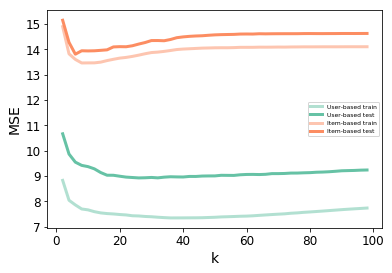

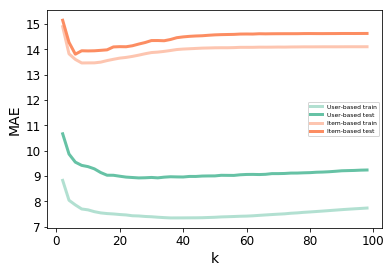

The recommendation for user 90280 is

By User-based MSE: User [114979 126991  33639    720 108318]

By User-based MAE: User [114979  33639    720 126991  64438]

By Item-based MSE: User [108318  78756   6796  34631  77713]

By Item-based MAE: User [108318  78756   6796  34631  77713]

The runtime of recommending data size of 200 is 0:04:12.106649


0

In [19]:
RecommenderSystem(ratings, 200, 100, 2, 5)

### 500 Users

-------Recommender system starts now--------
Sparsity of user training data: 5.82%
===User-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 144 is 7.302049821
Test data's MSE with the optimal_k 144 is 8.41970092842
---MAE---
Training data's MAE with the optimal_k 148 is 2.20891476349
Test data's MAE with the optimal_k 148 is 2.38675703371
===Item-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 24 is 12.9987128736
Test data's MSE with the optimal_k 24 is 13.2437454956
---MAE---
Training data's MAE with the optimal_k 38 is 2.96420876014
Test data's MAE with the optimal_k 38 is 2.98933745822


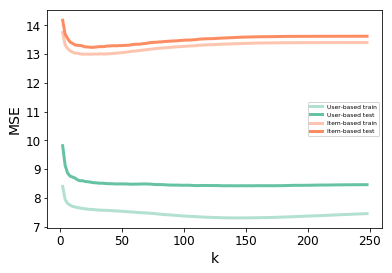

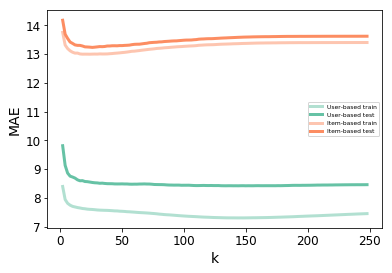

The recommendation for user 90280 is

By User-based MSE: User [114979  97383    607 108497  20949]

By User-based MAE: User [   607 114979  97383  21667 108497]

By Item-based MSE: User [ 61587  63343 129753  89474  76153]

By Item-based MAE: User [108318  76153  96095  36278  89474]

The runtime of recommending data size of 500 is 1:03:40.804284


0

In [22]:
RecommenderSystem(ratings, 500, 250, 2, 5)

###  Design choices we consider - overfitting issues
We discovered as we increase the neighborhood size, both user-based and item-based methods will encounter overfitting problems which leads to a low error. 

-------Recommender system starts now--------
Sparsity of user training data: 11.33%
===User-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 98 is 6.83797084631
Test data's MSE with the optimal_k 98 is 8.02637132989
---MAE---
Training data's MAE with the optimal_k 98 is 2.12847467038
Test data's MAE with the optimal_k 98 is 2.32003074575
===Item-based Collaborative Filtering Model===
---MSE---
Training data's MSE with the optimal_k 98 is 13.1216083917
Test data's MSE with the optimal_k 98 is 14.1941119479
---MAE---
Training data's MAE with the optimal_k 98 is 2.95471213431
Test data's MAE with the optimal_k 98 is 3.05822947949


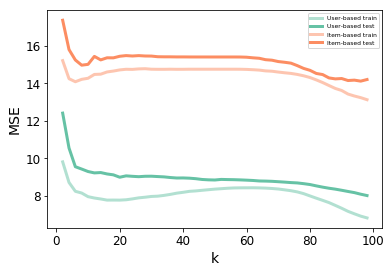

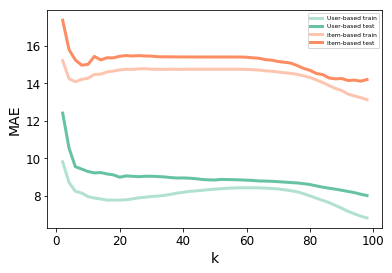

The recommendation for user 90280 is

By User-based MSE: User [ 64438    720  75801  33639 122782]

By User-based MAE: User [ 64438    720  75801  33639 122782]

By Item-based MSE: User [ 78756  47092 129753 116784  66503]

By Item-based MAE: User [ 78756  47092 129753 116784  66503]

The runtime of recommending data size of 100 is 0:01:06.592563


0

In [24]:
RecommenderSystem(ratings, 100, 100, 2, 5)

### Observations

##### Neighborhood size
We can discover the same pattern of how evaluation metrics varies with the neighborhood size. The evaluation metrics would first descend, and then at some k, the evaluation metrics would ascend. The k is therefore the optimal hyperparameter we are in search of to get the minimum error.

##### Relationship between overall accuracy and data size
We can clearly observe that in both User-based and Item-based approach, the error decreases as the sample data size increases.

##### Relationship between run time and data size
The run-time doesn’t scale well with data size. When our data size increases from 100 to 500 users, the run time increased by an hour, which is a considerable difference that can affect the business.